In [1]:
import os
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.utils import resample
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.datasets import cifar10
from collections import Counter
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping

### Reproducibility

In [2]:
SEED = 22
np.random.seed(SEED)
tf.random.set_seed(SEED)

### Set class number to train for

In [3]:
KEEP_CLASS_NUMBER = 7

### General functions

In [4]:
def get_class_summary(y):
    y_flat = y.flatten() 
    counter = Counter(y_flat)
    return counter

In [5]:
def plot_distribution(class_counts):
    labels, counts = zip(*sorted(class_counts.items()))
    label_names = [class_names[label] for label in labels]
    
    plt.figure(figsize=(10, 5))
    sns.barplot(x=label_names, y=counts)
    plt.title('Distribution of classes')
    plt.xlabel('Classes')
    plt.ylabel('Number of Images')
    plt.xticks(rotation=90)
    plt.tight_layout()
    plt.show()

In [6]:
def show_image_grid(X, y, rows, cols, figsize):
    # Create a new figure
    plt.figure(figsize=figsize)
  
    for i in range(rows*cols):
        plt.subplot(rows, cols, i+1)
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
        plt.imshow(X[i])
        plt.title(class_names[y[i][0]])
    
    plt.show()

#### CNN structure

In [7]:
def build_simple_cnn(input_shape=(32, 32, 3), num_classes=KEEP_CLASS_NUMBER):
    inputs = tf.keras.layers.Input(shape=input_shape)

    # CNN Block 1
    x = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', padding='same')(inputs)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', padding='same')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.AveragePooling2D((2, 2))(x)
    x = tf.keras.layers.Dropout(0.25)(x)

    # CNN Block 2
    x = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.AveragePooling2D((2, 2))(x)
    x = tf.keras.layers.Dropout(0.25)(x)

    # CNN Block 3
    x = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.AveragePooling2D((2, 2))(x)
    x = tf.keras.layers.Dropout(0.25)(x)

    cnn_output = tf.keras.layers.Flatten(name='cnn_output')(x)

    # Dense layers
    dense_1 = tf.keras.layers.Dense(128, activation='relu', name='dense_1')(cnn_output)
    dropout_1 = tf.keras.layers.Dropout(0.5)(dense_1)

    # Final layer (logits before softmax)
    logits = Dense(num_classes, name='logits')(dropout_1)
    outputs = tf.keras.layers.Softmax(name='softmax')(logits)

    model = tf.keras.Model(inputs=inputs, outputs=outputs)

    return model

#### Isolation forest

In [8]:
from sklearn.ensemble import IsolationForest

def fit_iso_forest(n_estimators, contamination, train_features, test_features):
    # Initialize the model
    iso_forest = IsolationForest(
        n_estimators=n_estimators,
        contamination=contamination,
        random_state=SEED
    )
    
    # Fit the model
    iso_forest.fit(train_features)
    
    # Predict anomalies (-1 = outlier, 1 = inlier)
    predictions = iso_forest.predict(test_features)
    
    # Get anomaly scores (the lower, the more anomalous)
    anomaly_scores = iso_forest.decision_function(test_features)

    return anomaly_scores, predictions

In [9]:
def get_outlier_stats(X, y, outlier_indices, anomaly_scores):
    X_outliers = X[outlier_indices]
    y_outliers = y[outlier_indices]
    scores = anomaly_scores[outlier_indices]
    df_outliers = pd.DataFrame({
        'label': y_outliers.flatten(),
        'score': scores
    })
    
    df_all = pd.DataFrame({
        'label': y_combined.flatten(),
        'score': anomaly_scores
    })
    
    # Group by label and compute mean score
    avg_scores_per_class = df_all.groupby('label')['score'].agg(
        mean_score='mean',
        min_score='min',
        max_score='max',
        std_score='std'
    ).reset_index()
    count_per_class = df_outliers.groupby('label')['score'].agg(
        count='count'
    ).reset_index()
    avg_scores_per_class['class_name'] = avg_scores_per_class['label'].apply(lambda x: class_names[x])
    count_per_class['class_name'] = count_per_class['label'].apply(lambda x: class_names[x])
    return avg_scores_per_class, count_per_class

In [10]:
def show_anomaly_score_plot(anomaly_scores):
    plt.hist(anomaly_scores, bins=50)
    plt.title("Anomaly Score Distribution")
    plt.xlabel("Score")
    plt.ylabel("Frequency")
    plt.show()

In [11]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
def print_evaluation_report(y_true, y_pred, target_names=['Unknown (OOD)', 'Known']):
    # Accuracy
    accuracy = accuracy_score(y_true, y_pred)
    print(f"Outlier Detection Accuracy: {accuracy*100:.2f}%")

    print(classification_report(y_true, y_pred, target_names=target_names))
    cm = confusion_matrix(y_true, y_pred, labels=[-1, 1])
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=target_names, yticklabels=target_names)
    plt.title("Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.show()


# Load dataset from library

In [12]:
(X_train, y_train), (X_test, y_test) = cifar10.load_data()

In [13]:
print('Train Images Shape:      ', X_train.shape)
print('Train Labels Shape:      ', y_train.shape)

print('\nTest Images Shape:       ', X_test.shape)
print('Test Labels Shape:       ', y_test.shape)

Train Images Shape:       (50000, 32, 32, 3)
Train Labels Shape:       (50000, 1)

Test Images Shape:        (10000, 32, 32, 3)
Test Labels Shape:        (10000, 1)


## CIFAR-10 classes

In [14]:
original_class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
class_names = ['bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck', 'automobile', 'airplane']

In [15]:
CLASS_NUMBER = 10

## Remap labels for easier handling

In [16]:
label_mapping = {original_class_names.index(name): class_names.index(name) for name in original_class_names}

In [17]:
y_train_mapped = np.vectorize(label_mapping.get)(y_train)
y_test_mapped = np.vectorize(label_mapping.get)(y_test)

# Exclude 3 classes from training
Excluded class: airplane, automobile, truck (last in list)

# Divide into trained and unknown classes

In [18]:
keep_classes = list(range(KEEP_CLASS_NUMBER))
other_classes = list(set(range(CLASS_NUMBER)) - set(range(KEEP_CLASS_NUMBER)))

# Masks
train_keep_mask = np.isin(y_train_mapped.flatten(), keep_classes)
test_keep_mask = np.isin(y_test_mapped.flatten(), keep_classes)

train_unknown_mask = np.isin(y_train_mapped.flatten(), other_classes)
test_unknown_mask = np.isin(y_test_mapped.flatten(), other_classes)

# Apply
X_train_filtered = X_train[train_keep_mask]
y_train_filtered = y_train_mapped[train_keep_mask]

X_test_filtered = X_test[test_keep_mask]
y_test_filtered = y_test_mapped[test_keep_mask]

X_train_unknown = X_train[train_unknown_mask]
y_train_unknown = y_train_mapped[train_unknown_mask]
X_test_unknown = X_test[test_unknown_mask]
y_test_unknown = y_test_mapped[test_unknown_mask]

In [19]:
print("Train labels and counts:", get_class_summary(y_train_filtered))
print("Test labels and counts:", get_class_summary(y_test_filtered))
print("Unknown train labels and counts:", get_class_summary(y_train_unknown))
print("Unknown test labels and counts:", get_class_summary(y_test_unknown))

Train labels and counts: Counter({4: 5000, 2: 5000, 0: 5000, 5: 5000, 6: 5000, 1: 5000, 3: 5000})
Test labels and counts: Counter({1: 1000, 6: 1000, 4: 1000, 3: 1000, 5: 1000, 2: 1000, 0: 1000})
Unknown train labels and counts: Counter({7: 5000, 8: 5000, 9: 5000})
Unknown test labels and counts: Counter({9: 1000, 8: 1000, 7: 1000})


# Plot class distribution

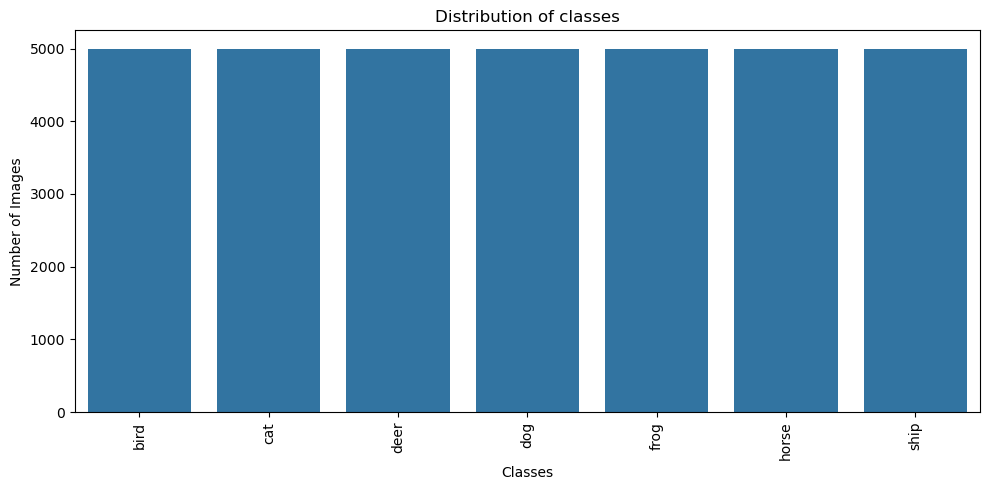

In [20]:
class_count =  get_class_summary(y_train_filtered)
plot_distribution(class_count)

# Examples

## Known classes

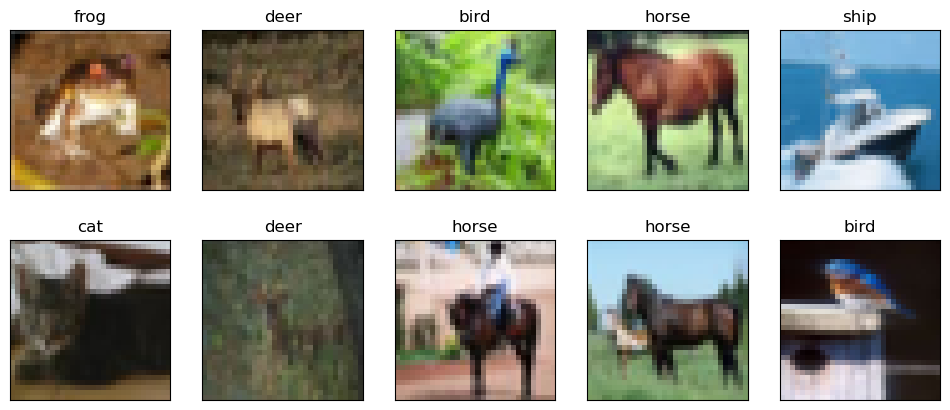

In [21]:
show_image_grid(X_train_filtered[:10], y_train_filtered[:10], 2, 5, (12,5))

## Unknown classes

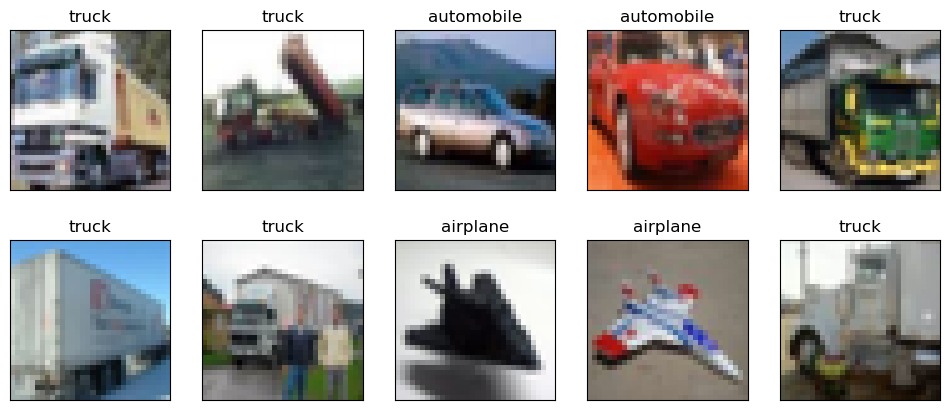

In [22]:
show_image_grid(X_train_unknown[:10], y_train_unknown[:10], 2, 5, (12,5))

# Preprocess images

## One-hot encoding of labels

In [23]:
enc = OneHotEncoder()
y_train_enc=enc.fit_transform(y_train_filtered).toarray().astype(int)
y_test_enc=enc.transform(y_test_filtered).toarray().astype(int)

## Flow generation

In [24]:
train_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255,
    rotation_range=10,
    width_shift_range=0.05,
    height_shift_range=0.05,
    horizontal_flip=True,
    validation_split=0.2
)

test_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255
)

In [25]:
train_flow = train_generator.flow(
    x=X_train_filtered,
    y=y_train_enc,
    batch_size=128,
    shuffle=True,
    seed=SEED,
    subset='training'
)

val_flow = train_generator.flow(
    x=X_train_filtered,
    y=y_train_enc,
    batch_size=128,
    shuffle=True,
    seed=SEED,
    subset='validation'
)

test_flow = test_generator.flow(
    x=X_test_filtered,
    y=y_test_enc,
    batch_size=128,
    shuffle=False
)

# Fit simple CNN for classification

In [32]:
my_model = build_simple_cnn()

### Compile model

In [33]:
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=1e-3,
    decay_steps=10000,
    decay_rate=0.9,
    staircase=True)

my_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lr_schedule), 
              loss='categorical_crossentropy', 
              metrics=['accuracy'])

### Fit model

In [34]:
my_history = my_model.fit(
    train_flow,
    validation_data=val_flow,
    epochs=50,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(
            monitor='val_loss',
            patience=10,
            restore_best_weights=True
        )
    ]
)

Epoch 1/50
219/219 [==============================] - 25s 108ms/step - loss: 1.5414 - accuracy: 0.4208 - val_loss: 3.1815 - val_accuracy: 0.1971
Epoch 2/50
219/219 [==============================] - 24s 111ms/step - loss: 1.2755 - accuracy: 0.5199 - val_loss: 1.4584 - val_accuracy: 0.4581
Epoch 3/50
219/219 [==============================] - 24s 111ms/step - loss: 1.1680 - accuracy: 0.5642 - val_loss: 1.2259 - val_accuracy: 0.5687
Epoch 4/50
219/219 [==============================] - 25s 113ms/step - loss: 1.0960 - accuracy: 0.5910 - val_loss: 1.2753 - val_accuracy: 0.5719
Epoch 5/50
219/219 [==============================] - 25s 114ms/step - loss: 1.0323 - accuracy: 0.6200 - val_loss: 0.9610 - val_accuracy: 0.6453
Epoch 6/50
219/219 [==============================] - 25s 112ms/step - loss: 0.9754 - accuracy: 0.6427 - val_loss: 0.9380 - val_accuracy: 0.6529
Epoch 7/50
219/219 [==============================] - 24s 110ms/step - loss: 0.9411 - accuracy: 0.6553 - val_loss: 0.9885 - val_ac

### Save weights to skip training in the future

In [35]:
my_model.save_weights('models/my_model_weights_7_class_v2.keras')

### Simply load saved weights

In [36]:
my_model.load_weights('models/my_model_weights_7_class_v2.keras')

### Evaluate model

In [37]:
loss, accuracy = my_model.evaluate(test_flow, verbose=1)
print(f"Test accuracy: {accuracy*100:.2f}%, test loss: {loss:.4f}")

55/55 [==============================] - 1s 20ms/step - loss: 0.6135 - accuracy: 0.8000
Test accuracy: 80.00%, test loss: 0.6135


### Get intermediate models

In [38]:
# Model to get CNN output (flattened)
cnn_output_model = tf.keras.Model(inputs=my_model.input, outputs=my_model.get_layer('cnn_output').output)

# Model to get first Dense output
dense_output_model = tf.keras.Model(inputs=my_model.input, outputs=my_model.get_layer('dense_1').output)

# Model to get logits (before softmax)
logits_model = tf.keras.Model(inputs=my_model.input, outputs=my_model.get_layer('logits').output)

# Extract features using different layers of the CNN classifier

## Construct datasets for outlier search

### 10% contamination in training set: 4500 known, 500 unknown elements

In [39]:
# Step 1: Get 500 from unknown
X_unknown_subset, _, y_unknown_subset, _ = train_test_split(
    X_train_unknown, y_train_unknown, test_size=(len(X_train_unknown) - 500), random_state=SEED, shuffle=True
)

# Step 2: Get 4500 from filtered
X_filtered_subset, _, y_filtered_subset, _ = train_test_split(
    X_train_filtered, y_train_filtered, test_size=(len(X_train_filtered) - 4500), random_state=SEED, shuffle=True
)

# Step 3: Combine
X_combined = np.concatenate([X_filtered_subset, X_unknown_subset], axis=0)
y_combined = np.concatenate([y_filtered_subset, y_unknown_subset], axis=0)

In [40]:
X_combined.shape, y_combined.shape

((5000, 32, 32, 3), (5000, 1))

In [41]:
subset_train_flow = train_generator.flow(X_combined, y_combined, batch_size=256, shuffle=True, seed=SEED)

### Generate balanaced test data out of 2500 known and 2500 unknown samples

In [42]:
# Step 1: Get 2500 from unknown
X_unknown_subset_test, _, y_unknown_subset_test, _ = train_test_split(
    X_train_unknown, y_train_unknown, test_size=(len(X_train_unknown) - 2500), random_state=SEED, shuffle=True
)

# Step 2: Get 2500 from filtered
X_filtered_subset_test, _, y_filtered_subset_test, _ = train_test_split(
    X_train_filtered, y_train_filtered, test_size=(len(X_train_filtered) - 2500), random_state=SEED, shuffle=True
)

# Step 3: Combine
X_combined_test = np.concatenate([X_filtered_subset_test, X_unknown_subset_test], axis=0)
y_combined_test = np.concatenate([y_filtered_subset_test, y_unknown_subset_test], axis=0)

# Step 4: Create "known vs unknown" labels
is_known = np.concatenate([
    np.ones(len(X_filtered_subset_test)),   # known = 1
    -1 * np.ones(len(X_unknown_subset_test))  # unknown = -1
])

In [43]:
X_combined_test.shape, y_combined_test.shape

((5000, 32, 32, 3), (5000, 1))

In [44]:
subset_test_flow = train_generator.flow(X_combined_test, y_combined_test, batch_size=256, shuffle=False, seed=SEED)

## CNN as feature extractor

In [45]:
train_features_cnn = cnn_output_model.predict(subset_train_flow, verbose=1)
test_features_cnn =  cnn_output_model.predict(subset_test_flow, verbose=1)

20/20 [==============================] - 3s 133ms/step


In [46]:
train_features_cnn.shape

(5000, 1024)

### Reduce feature number

In [47]:
from sklearn.decomposition import PCA

pca = PCA(n_components=256)
train_reduced_cnn = pca.fit_transform(train_features_cnn)
test_reduced_cnn = pca.fit_transform(test_features_cnn)

In [48]:
train_reduced_cnn.shape

(5000, 256)

### Fit isolation forest

In [49]:
anomaly_scores, predictions = fit_iso_forest(
    n_estimators = 100, 
    contamination = 0.1, 
    train_features = train_features_cnn, 
    test_features = test_features_cnn
)
outlier_indices = np.where(predictions == -1)[0]
avg_scores_per_class, count_per_class = get_outlier_stats(X_combined_test, y_combined_test, outlier_indices, anomaly_scores)

### Display results

Outlier Detection Accuracy: 47.74%
               precision    recall  f1-score   support

Unknown (OOD)       0.37      0.07      0.11      2500
        Known       0.49      0.89      0.63      2500

     accuracy                           0.48      5000
    macro avg       0.43      0.48      0.37      5000
 weighted avg       0.43      0.48      0.37      5000



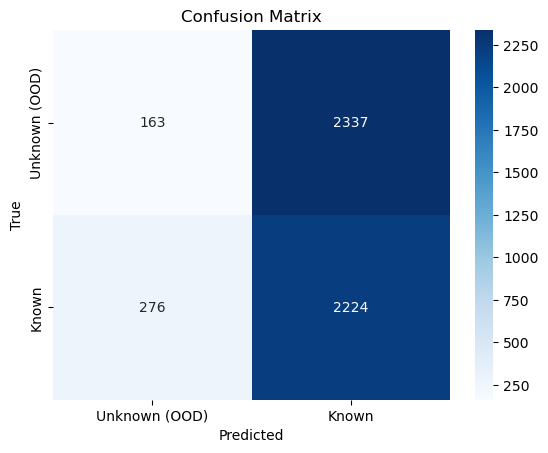

In [50]:
print_evaluation_report(is_known, predictions)

In [51]:
print("Global average anomaly scores")
print(avg_scores_per_class)

Global average anomaly scores
   label  mean_score  min_score  max_score  std_score  class_name
0      0    0.025994  -0.037405   0.067692   0.018222        bird
1      1    0.026674  -0.062382   0.071345   0.018868         cat
2      2    0.025738  -0.040459   0.076421   0.018129        deer
3      3    0.025721  -0.044889   0.069181   0.018591         dog
4      4    0.024510  -0.037224   0.071706   0.018050        frog
5      5    0.025419  -0.028506   0.068622   0.017719       horse
6      6    0.025126  -0.040027   0.071316   0.018090        ship
7      7    0.025373  -0.012648   0.060430   0.014460       truck
8      8    0.020359  -0.032570   0.057317   0.017676  automobile
9      9    0.034509  -0.013435   0.060275   0.014896    airplane


In [52]:
print("Outlier count")
print(count_per_class)

Outlier count
   label  count  class_name
0      0     19        bird
1      1     34         cat
2      2     14        deer
3      3     87         dog
4      4     26        frog
5      5     81       horse
6      6     15        ship
7      7     62       truck
8      8     77  automobile
9      9     24    airplane


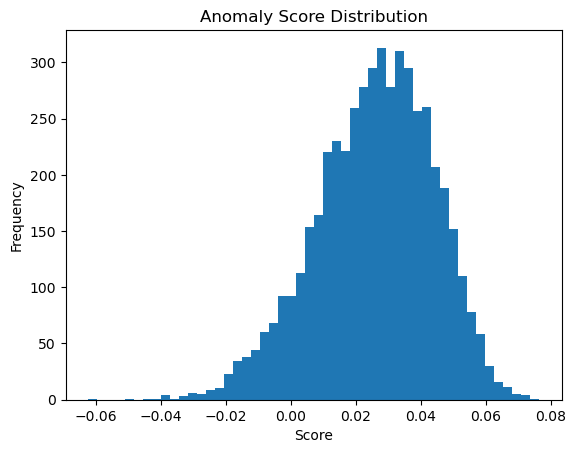

In [53]:
show_anomaly_score_plot(anomaly_scores)

## Dense layer features

In [54]:
train_features_dense = dense_output_model.predict(subset_train_flow, verbose=1)
test_features_dense =  dense_output_model.predict(subset_test_flow, verbose=1)

20/20 [==============================] - 3s 137ms/step


In [55]:
train_features_dense.shape

(5000, 128)

In [56]:
anomaly_scores, predictions = fit_iso_forest(
    n_estimators = 100, 
    contamination = 0.1, 
    train_features = train_features_dense, 
    test_features = test_features_dense
)
outlier_indices = np.where(predictions == -1)[0]
avg_scores_per_class, count_per_class = get_outlier_stats(X_combined_test, y_combined_test, outlier_indices, anomaly_scores)

### Display results

Outlier Detection Accuracy: 44.56%
               precision    recall  f1-score   support

Unknown (OOD)       0.06      0.01      0.01      2500
        Known       0.47      0.88      0.61      2500

     accuracy                           0.45      5000
    macro avg       0.27      0.45      0.31      5000
 weighted avg       0.27      0.45      0.31      5000



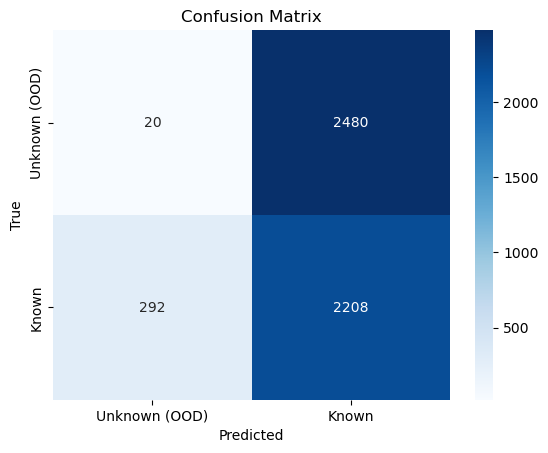

In [57]:
print_evaluation_report(is_known, predictions)

In [58]:
print("Global average anomaly scores")
print(avg_scores_per_class)

Global average anomaly scores
   label  mean_score  min_score  max_score  std_score  class_name
0      0    0.066683  -0.097347   0.130227   0.040094        bird
1      1    0.066940  -0.105709   0.127680   0.036648         cat
2      2    0.065090  -0.144865   0.129014   0.037940        deer
3      3    0.065441  -0.102967   0.126364   0.039895         dog
4      4    0.065882  -0.070509   0.128706   0.038128        frog
5      5    0.065174  -0.075110   0.123662   0.035749       horse
6      6    0.065837  -0.098531   0.123643   0.038997        ship
7      7    0.087210  -0.002271   0.129015   0.023368       truck
8      8    0.077725  -0.018194   0.127181   0.028337  automobile
9      9    0.076061  -0.019203   0.125662   0.026071    airplane


In [59]:
print("Outlier count")
print(count_per_class)

Outlier count
   label  count  class_name
0      0     31        bird
1      1     20         cat
2      2     26        deer
3      3     45         dog
4      4     60        frog
5      5     49       horse
6      6     61        ship
7      7      6       truck
8      8      9  automobile
9      9      5    airplane


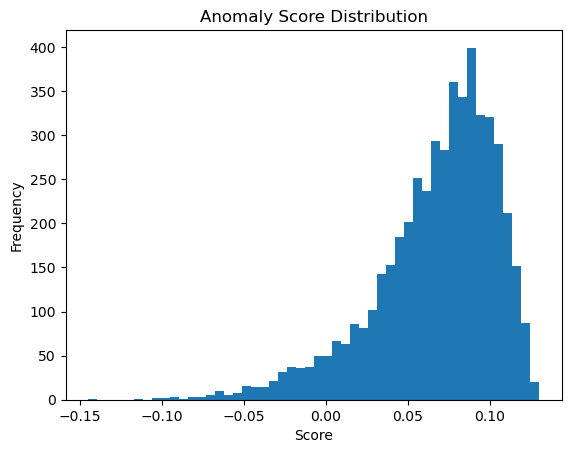

In [60]:
show_anomaly_score_plot(anomaly_scores)

## Logits

In [61]:
train_features_logits = logits_model.predict(subset_train_flow, verbose=1)
test_features_logits =  logits_model.predict(subset_test_flow, verbose=1)

20/20 [==============================] - 3s 134ms/step


In [62]:
train_features_logits.shape

(5000, 7)

In [63]:
anomaly_scores, predictions = fit_iso_forest(
    n_estimators = 100, 
    contamination = 0.1, 
    train_features = train_features_logits, 
    test_features = test_features_logits
)
outlier_indices = np.where(predictions == -1)[0]
avg_scores_per_class, count_per_class = get_outlier_stats(X_combined_test, y_combined_test, outlier_indices, anomaly_scores)

### Display results

Outlier Detection Accuracy: 45.26%
               precision    recall  f1-score   support

Unknown (OOD)       0.13      0.02      0.03      2500
        Known       0.47      0.89      0.62      2500

     accuracy                           0.45      5000
    macro avg       0.30      0.45      0.32      5000
 weighted avg       0.30      0.45      0.32      5000



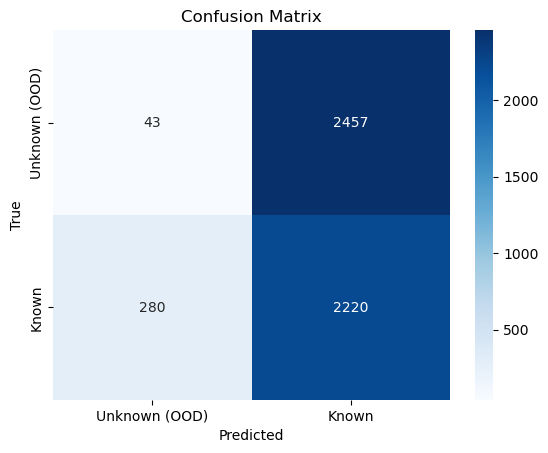

In [64]:
print_evaluation_report(is_known, predictions)

In [65]:
print("Global average anomaly scores")
print(avg_scores_per_class)

Global average anomaly scores
   label  mean_score  min_score  max_score  std_score  class_name
0      0    0.081192  -0.126525   0.146814   0.046287        bird
1      1    0.083157  -0.136911   0.146242   0.044365         cat
2      2    0.080730  -0.146360   0.144096   0.045519        deer
3      3    0.077891  -0.151508   0.145704   0.049505         dog
4      4    0.078356  -0.108550   0.145155   0.046090        frog
5      5    0.080277  -0.149740   0.143538   0.044887       horse
6      6    0.079295  -0.141072   0.144970   0.047000        ship
7      7    0.096581  -0.002300   0.136952   0.027391       truck
8      8    0.089540  -0.023778   0.142768   0.032843  automobile
9      9    0.089340  -0.016147   0.141628   0.033930    airplane


In [66]:
print("Outlier count")
print(count_per_class)

Outlier count
   label  count  class_name
0      0     10        bird
1      1     14         cat
2      2     26        deer
3      3     56         dog
4      4     35        frog
5      5     99       horse
6      6     40        ship
7      7      8       truck
8      8     18  automobile
9      9     17    airplane


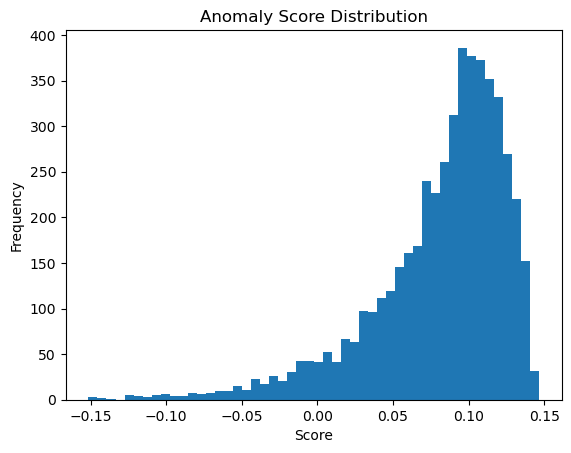

In [67]:
show_anomaly_score_plot(anomaly_scores)

## Model output

In [68]:
train_features = my_model.predict(subset_train_flow, verbose=1)
test_features =  my_model.predict(subset_test_flow, verbose=1)

20/20 [==============================] - 3s 132ms/step


In [69]:
train_features.shape

(5000, 7)

In [70]:
anomaly_scores, predictions = fit_iso_forest(
    n_estimators = 100, 
    contamination = 0.1, 
    train_features = train_features, 
    test_features = test_features
)
outlier_indices = np.where(predictions == -1)[0]
avg_scores_per_class, count_per_class = get_outlier_stats(X_combined_test, y_combined_test, outlier_indices, anomaly_scores)

### Display results

Outlier Detection Accuracy: 58.84%
               precision    recall  f1-score   support

Unknown (OOD)       0.77      0.25      0.38      2500
        Known       0.55      0.92      0.69      2500

     accuracy                           0.59      5000
    macro avg       0.66      0.59      0.54      5000
 weighted avg       0.66      0.59      0.54      5000



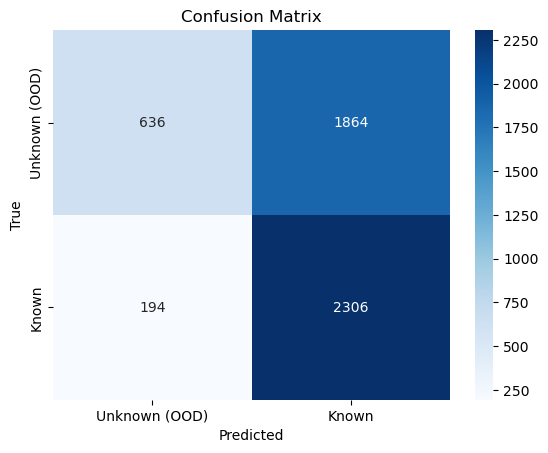

In [71]:
print_evaluation_report(is_known, predictions)

In [72]:
print("Global average anomaly scores")
print(avg_scores_per_class)

Global average anomaly scores
   label  mean_score  min_score  max_score  std_score  class_name
0      0    0.053682  -0.034193   0.133793   0.049429        bird
1      1    0.056064  -0.043043   0.133793   0.050981         cat
2      2    0.059400  -0.046343   0.133793   0.047783        deer
3      3    0.058894  -0.050957   0.133793   0.050218         dog
4      4    0.059254  -0.054588   0.133793   0.050306        frog
5      5    0.055949  -0.038496   0.133793   0.049656       horse
6      6    0.053675  -0.042696   0.133793   0.050429        ship
7      7    0.056088  -0.032006   0.133793   0.058390       truck
8      8    0.065320  -0.044132   0.133793   0.056917  automobile
9      9    0.051233  -0.042611   0.133793   0.055333    airplane


In [73]:
print("Outlier count")
print(count_per_class)

Outlier count
   label  count  class_name
0      0     54        bird
1      1     61         cat
2      2     28        deer
3      3     21         dog
4      4     15        frog
5      5     10       horse
6      6      5        ship
7      7    229       truck
8      8    156  automobile
9      9    251    airplane


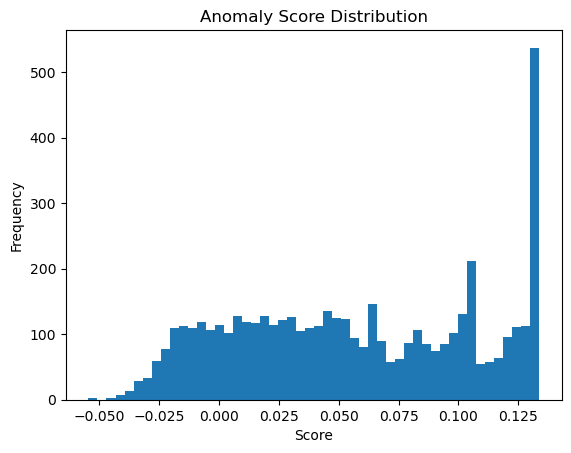

In [74]:
show_anomaly_score_plot(anomaly_scores)